In [2]:
import librosa as lb
import librosa.display
import scipy
import json
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import keras
from keras.utils import np_utils
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from model_builder import build_example
from plotter import plot_history
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# CONSTANTS

DATA_DIR = "openmic-2018/"
CATEGORY_COUNT = 8
LEARNING_RATE = 0.00001
THRESHOLD = 0.5

(220544,)
22050
(128, 431)
(128, 431)


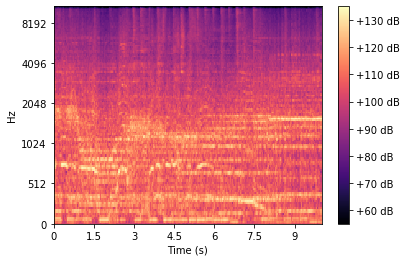

In [4]:
# MEL-SPECTOGRAM EXAMPLE

y, sr = lb.load(DATA_DIR + 'audio/000/000135_483840.ogg')
S = lb.feature.melspectrogram(y=y, sr=sr)

S_dB = lb.power_to_db(S, ref=0) # 10 * log10(S / ref)


print(y.shape)
print(sr)
print(S.shape)
print(S_dB.shape)

librosa.display.specshow(S_dB, x_axis='s', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [5]:
MEL = []
sum = 0
for i in range(X.shape[0]):
    key = sample_key[i]
    key_pref = key[:3]
    y, sr = lb.load(DATA_DIR + 'audio/' + key_pref + '/' + key + '.ogg')
    S = lb.feature.melspectrogram(y=y, sr=sr)
    S_dB = lb.power_to_db(S, ref=0)
    MEL.append(S_dB[:,:430])
    


NameError: name 'X' is not defined

In [ ]:
MEL_S = np.asarray(MEL)
print('Mel has shape: ' + str(MEL_S.shape))

In [ ]:
# TODO SAVE WITHOUT X

np.savez('openmic-test-delete.npz', MEL = X, Y_true=Y_true, Y_mask=Y_mask, sample_key=sample_key)

In [ ]:
np.savez_compressed('openmic-mel-only.npz', MEL = MEL_S)
print('OpenMIC keys: ' + str(list(OPENMIC_2.keys())))

In [ ]:

OPENMIC_2 = np.load(os.path.join(DATA_DIR, 'openmic-mel.npz'), allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC_2['MEL'], OPENMIC_2['Y_true'], OPENMIC_2['Y_mask'], OPENMIC_2['sample_key']


In [ ]:
# LOAD DATA

OPENMIC = np.load(os.path.join(DATA_DIR, 'openmic-2018.npz'), allow_pickle=True)
print('OpenMIC keys: ' + str(list(OPENMIC.keys())))
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']
print('X has shape: ' + str(X.shape))
print('Y_true has shape: ' + str(Y_true.shape))
print('Y_mask has shape: ' + str(Y_mask.shape))
print('sample_key has shape: ' + str(sample_key.shape))

In [ ]:
# LOAD LABELS

with open(os.path.join(DATA_DIR, 'class-map.json'), 'r') as f:
    INSTRUMENTS = json.load(f)
print('OpenMIC instruments: ' + str(INSTRUMENTS))

In [ ]:
# SPLIT DATA (TRAIN - TEST - VAL)

# CHANGE X TO MEL
split_train, split_test, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test = train_test_split(sample_key, X, Y_true, Y_mask)
split_val, split_test, X_val, X_test, Y_true_val, Y_true_test, Y_mask_val, Y_mask_test = train_test_split(split_test, X_test, Y_true_test, Y_mask_test, test_size=0.5)
train_set = np.asarray(set(split_train))
test_set = np.asarray(set(split_test))
print('# Train: {}, # Val: {}, # Test: {}'.format(len(split_train), len(split_test), len(split_val)))

In [ ]:
# DUPLICATE OF THE MODEL PREPROCESS

print(X_train.shape)
print(X_test.shape)

for instrument in INSTRUMENTS:
    
    # Map the instrument name to its column number
    inst_num = INSTRUMENTS[instrument]

    print(instrument)
    
    # TRAIN
    train_inst = Y_mask_train[:, inst_num]
    X_train_inst = X_train[train_inst]
    X_train_inst = X_train_inst.astype('float16')
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= THRESHOLD
    i = 0
    for val in Y_true_train_inst:
        i += val
        
    print('TRAIN: ' + str(i) + ' true of ' + str(len(Y_true_train_inst)) + ' (' + str(round(i / len(Y_true_train_inst ) * 100,2)) + ' %)' )
        
    
    # TEST
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst = X_test_inst.astype('float16')
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= THRESHOLD
    
    i = 0
    for val in Y_true_test_inst:
        i += val
        
    print('TEST: ' + str(i) + ' true of ' + str(len(Y_true_test_inst)) + ' (' + str(round(i / len(Y_true_test_inst ) * 100,2)) + ' %)' )
    
    
    # VALIDATION
    val_inst = Y_mask_val[:, inst_num]
    X_val_inst = X_val[val_inst]
    X_val_inst = X_val_inst.astype('float16')
    shape = X_val_inst.shape
    X_val_inst = X_val_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_val_inst = Y_true_val[val_inst, inst_num] >= THRESHOLD
    
    
    i = 0
    for val in Y_true_val_inst:
        i += val
    print('VALIDATION: ' + str(i) + ' true of ' + str(len(Y_true_val_inst)) + ' (' + str(round(i / len(Y_true_val_inst ) * 100,2)) + ' %)' )

In [ ]:
# VALAMI FANCY ADATKIÍRÁS
len(Y_true_val_inst)


In [ ]:
# This dictionary will include the classifiers for each model
mymodels = dict()
# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in INSTRUMENTS:
    
    # Map the instrument name to its column number
    inst_num = INSTRUMENTS[instrument]

    # Step 1: sub-sample the data
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    
    # TRAIN
    train_inst = Y_mask_train[:, inst_num]
    X_train_inst = X_train[train_inst]
    X_train_inst = X_train_inst.astype('float16')
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= THRESHOLD
    
    # TEST
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst = X_test_inst.astype('float16')
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= THRESHOLD
    
    # VALIDATION
    val_inst = Y_mask_val[:, inst_num]
    X_val_inst = X_val[val_inst]
    X_val_inst = X_val_inst.astype('float16')
    shape = X_val_inst.shape
    X_val_inst = X_val_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_val_inst = Y_true_val[val_inst, inst_num] >= THRESHOLD
    

    # Step 3.
    # Initialize a new classifier
    model = models.Sequential()
    model.add(Conv2D(input_shape=(1,128,430),data_format="channels_first",filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr= LEARNING_RATE), metrics = ['accuracy'])

    # model.summary()
    # Step 4.
    history = model.fit(X_train_inst,Y_true_train_inst , epochs=10, batch_size=64, validation_data=(X_val_inst,Y_true_val_inst))
    
    plot_history(history)
    
    loss, acc = model.evaluate(X_test_inst, Y_true_test_inst)
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {:.2%}'.format(acc))
    # Step 5.
    # Finally, we'll evaluate the model on both train and test
    Y_pred_train = model.predict(X_train_inst)
    Y_pred_test = model.predict(X_test_inst)
    Y_pred_train_bool = Y_pred_train > THRESHOLD - 0.15 #THRESHOLD (should be lower than 0.5)
    Y_pred_test_bool = Y_pred_test > THRESHOLD - 0.15 #THRESHOLD (should be lower than 0.5)
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train_bool))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_bool))

    # Store the classifier in our dictionary
mymodels[instrument] = model

In [ ]:

import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow, xlim, ylim, title


def plot_history():
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper left')
    plt.show()

In [ ]:
""""
    # Step 3: simplify the data by averaging over time
    # Instead of having time-varying features, we'll summarize each track by its mean feature vector over time
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    X_train_inst_sklearn = X_train_inst_sklearn.astype('float32')
    X_train_inst_sklearn = lb.util.normalize(X_train_inst_sklearn)
"""

np.savez('models.npz',model=)